In [25]:
import os
from bs4 import BeautifulSoup
from playwright.async_api import async_playwright, TimeoutError as playwrightTimeout
import time
import requests
from pathlib import Path
import pandas as pd
from io import StringIO

In [3]:
#list of years
SEASONS= list(range(2018, 2026))

In [4]:
#Switching playwright with beautiful soup and requests
def get_html(url):
    response = requests.get(url)
    response.raise_for_status()
    return response.text

In [5]:

base_dir = Path().resolve()
standings_dir = base_dir / "standings_dir"

#function that scrapes the standings table and saves the links of monthly box scores
def get_month_links(season):
    base_url = f"https://www.basketball-reference.com/leagues/NBA_{season}_games.html"
    response = requests.get(base_url)
    soup = BeautifulSoup(response.text, 'html.parser')

    filter_div = soup.find('div', class_='filter')
    links = filter_div.find_all('a')
    month_urls = ['https://www.basketball-reference.com' + a['href'] for a in links]

    for link in month_urls:
        month = link.split('_')[-1].split('.')[0]  # e.g. "october"
        month_response = requests.get(link)
        month_soup = BeautifulSoup(month_response.text, 'html.parser')

        table = month_soup.select_one('#all_schedule')
        if table:
            file_path = standings_dir / f"{season}_{month}.html"
            with open(file_path, 'w', encoding='utf-8') as f:
                f.write(str(table))
            print(f"Saved {file_path}")
        else:
            print(f"No table found on {link}")

In [12]:
get_month_links(2025)

Saved /Users/user/Desktop/Code/pyWebs/notebooks/standings_dir/2025_games-october.html
Saved /Users/user/Desktop/Code/pyWebs/notebooks/standings_dir/2025_games-november.html
Saved /Users/user/Desktop/Code/pyWebs/notebooks/standings_dir/2025_games-december.html
Saved /Users/user/Desktop/Code/pyWebs/notebooks/standings_dir/2025_games-january.html
Saved /Users/user/Desktop/Code/pyWebs/notebooks/standings_dir/2025_games-february.html
Saved /Users/user/Desktop/Code/pyWebs/notebooks/standings_dir/2025_games-march.html
Saved /Users/user/Desktop/Code/pyWebs/notebooks/standings_dir/2025_games-april.html
Saved /Users/user/Desktop/Code/pyWebs/notebooks/standings_dir/2025_games-may.html


In [31]:

#function to save yearly advanced stats 
def advanced_stats(year):
    base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html"
    # Send HTTP request to the URL to avoid being blocked again
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    response = requests.get(base_url, headers=headers)
    
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', id='advanced')
    
    if not table:
        raise Exception("Advanced stats table not found on the page")
    
    # Convert table to DataFrame
    df = pd.read_html(StringIO(str(table)))[0]
    
    # Clean the DataFrame
    # Remove rows that are used as header separators in the table
    df = df[~df['Player'].str.contains('Player', na=False)]
    
    # Remove duplicate column headers that appear in the middle of the table
    df = df[df['Rk'] != 'Rk']
    
    # Reset the index
    df = df.reset_index(drop=True)
    
    # Create 'advance' directory if it doesn't exist
    os.makedirs('advance', exist_ok=True)
    
    # Save to CSV
    output_path = f"advance/nba_advanced_stats_{year}.csv"
    df.to_csv(output_path, index=False)
    
    print(f"Advanced stats for {year} NBA season saved to {output_path}")
    return output_path


In [30]:
#scraped all the years one by one, gave like a minute interval 
year = 2025
file_path = advanced_stats(year)
print(f"Data saved to: {file_path}")

Advanced stats for 2025 NBA season saved to advance/nba_advanced_stats_2025.csv
Data saved to: advance/nba_advanced_stats_2025.csv


In [38]:
#function to save yearly per_game stats
def per_game_stats(year):
    base_url = f"https://basketball-reference.com/leagues/NBA_{year}_per_game.html"
    response = requests.get(base_url)
    soup = BeautifulSoup(response.content, 'html.parser')

    table = soup.find('table', id='per_game_stats')
    
    df = pd.read_html(StringIO(str(table)))[0]
    df = df[~df['Player'].str.contains('Player', na=False)]
    
    df = df[df['Rk'] != 'Rk']

    df = df.reset_index(drop=True)

    os.makedirs('per_game_stats', exist_ok=True)

    output_path = f"per_game_stats/nba_per_game_stats_{year}.csv"
    df.to_csv(output_path, index=False)
    
    print(f"Per_game stats for {year} NBA season saved to {output_path}")
    return output_path
    


In [46]:
year = 2025
file_path = per_game_stats(year)
print(f"Data saved to: {file_path}")

Per_game stats for 2025 NBA season saved to per_game_stats/nba_per_game_stats_2025.csv
Data saved to: per_game_stats/nba_per_game_stats_2025.csv


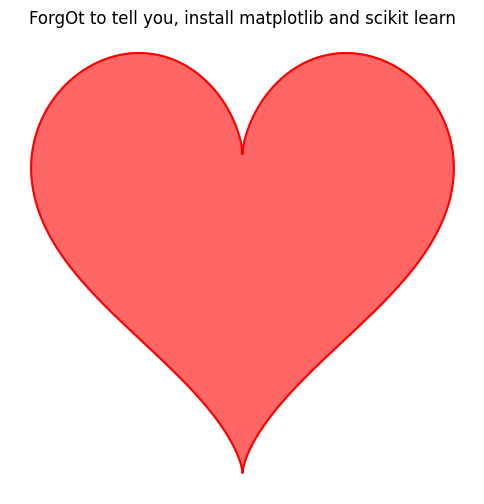

In [11]:
#JUST TESTING OUT VISUALIZATIONS
#so not important
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, 2 * np.pi, 1000)

x = 16 * np.sin(t) ** 3
y = 13 * np.cos(t) - 5 * np.cos(2*t) - 2 * np.cos(3*t) - np.cos(4*t)

plt.figure(figsize=(6, 6))
plt.plot(x, y, color='red')
plt.fill(x, y, color='red', alpha=0.6)
plt.title('Forgot to tell you, install matplotlib and scikit learn')
plt.axis('off')
plt.show()
